In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
no_epochs = 50
learning_rate = 0.001
batch_size = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

acc_function = MulticlassAccuracy(num_classes=102, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

SEED = 42
np.random.seed(SEED)
gen = torch.manual_seed(SEED)

cuda:0


In [3]:
# Data Augmentation
train_transforms = v2.Compose([
    v2.RandomRotation(30),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

default_transforms = v2.Compose([
    models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
def get_data_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=gen)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=gen)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=gen)
    return train_loader, test_loader, val_loader

In [5]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=3, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss_value / len(dataloader)

def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    return running_acc_value*100, running_loss_value

def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, training_time = [], [], [], [], []
    for i in range(no_epochs):
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        end = datetime.datetime.now()
        time_taken = (end - start).total_seconds()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Time Taken: {time_taken:>0.2f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        training_time.append(time_taken)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, training_time

In [7]:
def create_VGG_model():
    model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
    new_classifier_head = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 102)
    )
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = new_classifier_head

    return model.to(device=device)

def create_resnet_model(size=50):
    match size:
        case 18:
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            new_fc = nn.Linear(512,102)
        case 34:
            model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
            new_fc = nn.Linear(512,102)
        case 50:
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            new_fc = nn.Linear(2048, 102)
        case 101:
            model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
            new_fc = nn.Linear(2048,102)
        case _:
            print("Invalid Size, defaulting to 50")
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            new_fc = nn.Linear(2048, 102)
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = new_fc
    
    return model.to(device)

def create_efficientnet_model(size):
    match size:
        case 's':
            model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        case 'm':
            model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
        case 'l':
            model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)
        case _:
            model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)



    for param in model.parameters():
        param.requires_grad = False
        
    new_classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(1280, 102)
    )
    
    model.classifier = new_classifier
    
    return model.to(device)

In [8]:
train_data_loader, test_data_loader, val_data_loader = get_data_loader(batch_size)

In [9]:
VGG_model = create_VGG_model()
print("VGG16")
VGG_train_acc, VGG_train_loss, VGG_eval_acc, VGG_eval_loss, VGG_test_acc, VGG_test_loss, VGG_training_time = train_eval_test(
    VGG_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del VGG_model

VGG16
Epoch 1 Train Loss: 4.900608, Eval Accuracy: 4.91%, Eval Loss: 4.539280, Time Taken: 13.16s
Epoch 2 Train Loss: 4.481932, Eval Accuracy: 14.60%, Eval Loss: 4.052787, Time Taken: 10.80s
Test Accuracy: 11.36798469387755, Test Loss: 4.145599637712751


In [10]:
ResNet_18_model = create_resnet_model(18)
print("RESNET18")
ResNet18_train_acc, ResNet18_train_loss, ResNet18_eval_acc, ResNet18_eval_loss, ResNet18_test_acc, ResNet18_test_loss, ResNet18_training_time = train_eval_test(
    ResNet_18_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_18_model

RESNET18
Epoch 1 Train Loss: 4.735284, Eval Accuracy: 5.39%, Eval Loss: 4.371781, Time Taken: 6.81s
Epoch 2 Train Loss: 4.214572, Eval Accuracy: 15.69%, Eval Loss: 3.971563, Time Taken: 6.65s
Test Accuracy: 16.3265306122449, Test Loss: 3.9754426138741628


In [11]:
ResNet_34_model = create_resnet_model(34)
print("RESNET34")
ResNet34_train_acc, ResNet34_train_loss, ResNet34_eval_acc, ResNet34_eval_loss, ResNet34_test_acc, ResNet34_test_loss, ResNet34_training_time = train_eval_test(
    ResNet_34_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_34_model

RESNET34
Epoch 1 Train Loss: 4.771635, Eval Accuracy: 5.19%, Eval Loss: 4.412210, Time Taken: 7.10s
Epoch 2 Train Loss: 4.240053, Eval Accuracy: 15.00%, Eval Loss: 3.994116, Time Taken: 7.08s
Test Accuracy: 14.811862244897958, Test Loss: 3.9990712963804906


In [12]:
ResNet_50_model = create_resnet_model(50)
print("RESNET50")
ResNet50_train_acc, ResNet50_train_loss, ResNet50_eval_acc, ResNet50_eval_loss, ResNet50_test_acc, ResNet50_test_loss, ResNet50_training_time = train_eval_test(
    ResNet_50_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_50_model

RESNET50
Epoch 1 Train Loss: 4.558015, Eval Accuracy: 22.57%, Eval Loss: 4.300018, Time Taken: 9.03s
Epoch 2 Train Loss: 4.156015, Eval Accuracy: 48.13%, Eval Loss: 3.964513, Time Taken: 8.48s
Test Accuracy: 47.35650511420503, Test Loss: 3.988689033352599


In [13]:
ResNet_101_model = create_resnet_model(101)
print("RESNET101")
ResNet101_train_acc, ResNet101_train_loss, ResNet101_eval_acc, ResNet101_eval_loss, ResNet101_test_acc, ResNet101_test_loss, ResNet101_training_time = train_eval_test(
    ResNet_101_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_101_model

RESNET101
Epoch 1 Train Loss: 4.579921, Eval Accuracy: 10.77%, Eval Loss: 4.261345, Time Taken: 10.66s
Epoch 2 Train Loss: 4.049811, Eval Accuracy: 40.91%, Eval Loss: 3.845064, Time Taken: 10.73s
Test Accuracy: 40.9311224611438, Test Loss: 3.846996443612235


In [14]:
efficientnet_s_model = create_efficientnet_model('s')

print("EFFICIENTNET_S")

ENs_train_acc, ENs_train_loss, ENs_eval_acc, ENs_eval_loss, ENs_test_acc, ENs_test_loss, ENs_training_time = train_eval_test(
    efficientnet_s_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del efficientnet_s_model

EFFICIENTNET_S
Epoch 1 Train Loss: 4.572298, Eval Accuracy: 11.20%, Eval Loss: 4.354647, Time Taken: 8.97s
Epoch 2 Train Loss: 4.189157, Eval Accuracy: 31.56%, Eval Loss: 4.032428, Time Taken: 8.69s
Test Accuracy: 29.065688775510207, Test Loss: 4.062666206943746


In [15]:
efficientnet_m_model = create_efficientnet_model('m')

print("EFFICIENTNET_M")

ENm_train_acc, ENm_train_loss, ENm_eval_acc, ENm_eval_loss, ENm_test_acc, ENm_test_loss, ENm_training_time = train_eval_test(
    efficientnet_m_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del efficientnet_m_model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to C:\Users\Elliot/.cache\torch\hub\checkpoints\efficientnet_v2_m-dc08266a.pth
100.0%


EFFICIENTNET_M
Epoch 1 Train Loss: 4.604946, Eval Accuracy: 7.46%, Eval Loss: 4.421230, Time Taken: 11.20s
Epoch 2 Train Loss: 4.301491, Eval Accuracy: 23.72%, Eval Loss: 4.183034, Time Taken: 11.57s
Test Accuracy: 19.74808674077598, Test Loss: 4.210172166629714


In [16]:
efficientnet_l_model = create_efficientnet_model('l')

print("EFFICIENTNET_L")

ENl_train_acc, ENl_train_loss, ENl_eval_acc, ENl_eval_loss, ENl_test_acc, ENl_test_loss, ENl_training_time = train_eval_test(
    efficientnet_l_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del efficientnet_l_model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to C:\Users\Elliot/.cache\torch\hub\checkpoints\efficientnet_v2_l-59c71312.pth
100.0%


EFFICIENTNET_L
Epoch 1 Train Loss: 4.651152, Eval Accuracy: 13.53%, Eval Loss: 4.089356, Time Taken: 17.13s
Epoch 2 Train Loss: 3.832237, Eval Accuracy: 42.35%, Eval Loss: 3.399445, Time Taken: 16.21s
Test Accuracy: 36.23405612853109, Test Loss: 3.5105240442314924


In [17]:
eval_acc = [VGG_eval_acc, ResNet18_eval_acc, ResNet34_eval_acc, ResNet50_eval_acc, ResNet101_eval_acc, ENs_eval_acc, ENm_eval_acc, ENl_eval_acc]
eval_acc = [np.mean(x) for x in eval_acc]
test_acc = [VGG_test_acc, ResNet18_test_acc, ResNet34_test_acc, ResNet50_test_acc, ResNet101_test_acc, ENs_test_acc, ENm_test_acc, ENl_test_acc]
time_taken = [VGG_training_time, ResNet18_training_time, ResNet34_training_time, ResNet50_training_time, ResNet101_training_time, ENs_training_time, ENm_training_time, ENl_training_time]
time_taken = [np.mean(x) for x in time_taken]
names = ['VGG16', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'EfficientNet_S', 'EfficientNet_M', 'EfficientNet_L']
colours = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

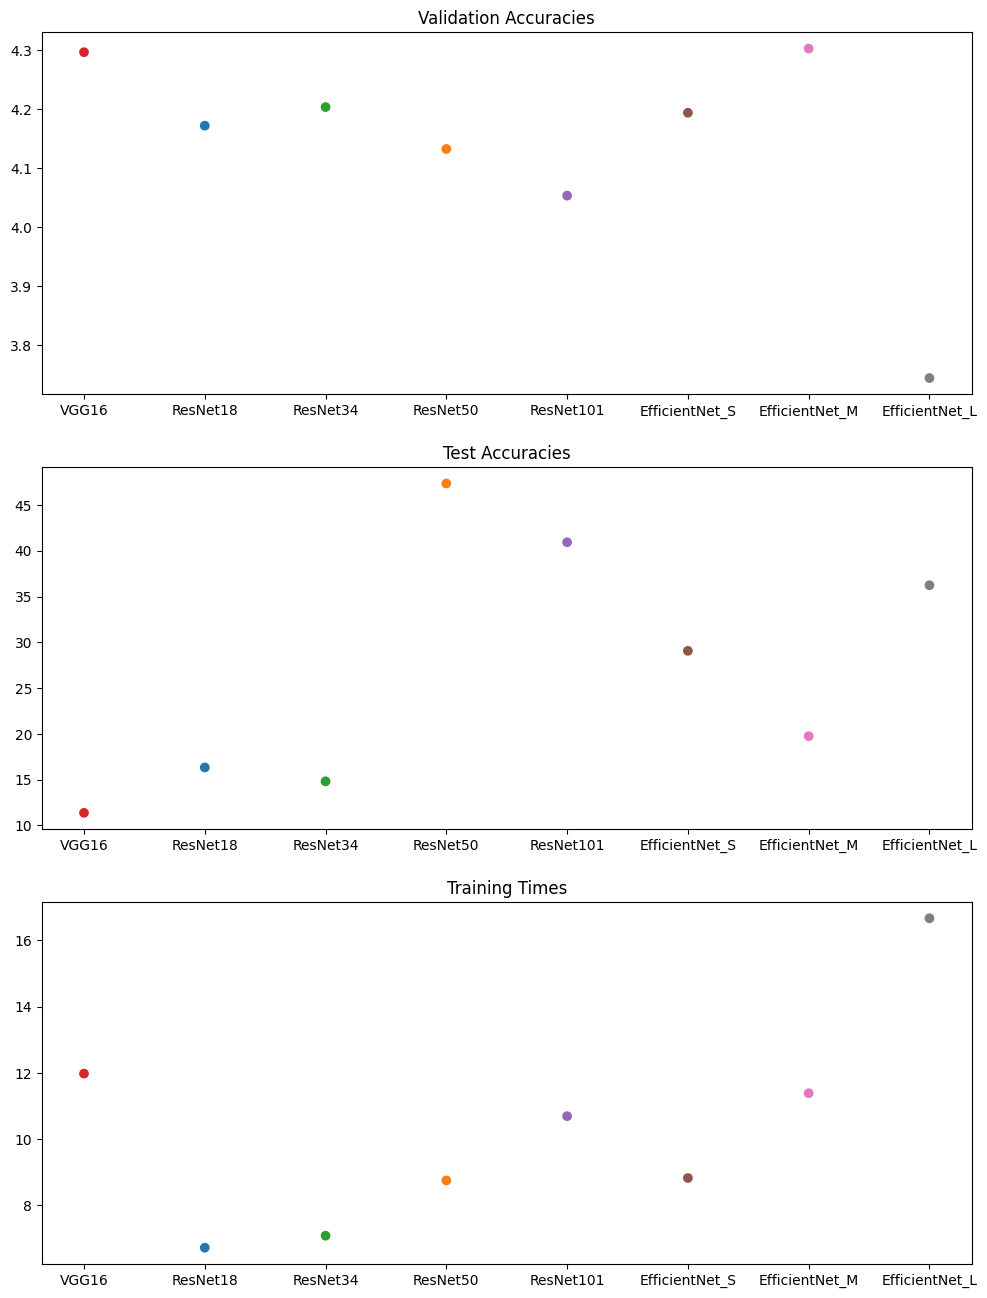

In [28]:
plt.figure(figsize=(12, 16))
plt.subplot(311)
plt.title('Validation Accuracies')
plt.scatter(names, eval_acc, color=colours)
plt.subplot(312)
plt.title('Test Accuracies')
plt.scatter(names, test_acc, color=colours)
plt.subplot(313)
plt.title('Training Times')
plt.scatter(names, time_taken, color=colours)
plt.show()

In [20]:
df = pd.DataFrame(
    np.column_stack([
        eval_acc,
        test_acc,
        time_taken
    ]),
    columns=['Validation Accuracy', 'Test Accuracy', 'Training Time'],
    index=names
)
df

,Validation Accuracy,Test Accuracy,Training Time
VGG16,4.296034,11.367985,11.978766
ResNet18,4.171672,16.326531,6.726591
ResNet34,4.203163,14.811862,7.088038
ResNet50,4.132265,47.356505,8.755071
ResNet101,4.053204,40.931122,10.695755
EfficientNet_S,4.193537,29.065689,8.828862
EfficientNet_M,4.302132,19.748087,11.388348
EfficientNet_L,3.744400,36.234056,16.668178
